In [21]:
# import libraries

import pandas as pd 
import matplotlib.pyplot as plt

#### **Tabla 1: Business**

In [22]:
# Create Pandas dataframe from JSON file
business = pd.read_json('./../data/yelp_business.json', lines=True)
business.head(3) 

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


#### **Tabla 2: User Reviews**

In [23]:
# Create Pandas dataframe from CSV file
reviews = pd.read_csv('./../data/yelp_reviews_subset.csv')
reviews.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,wek3rf2MRDhyCBRR9iiGlA,vjY9m43zBdUDrmTfUMJ75g,W4ZEKkva9HpAdZG88juwyQ,5.0,0,0,0,This is a really great restaurant with awesome...,2019-12-06 04:19:05
1,szh4wJ2VjLHOOhsT1V7Dfg,qIFbnyVpwAzywSKQbSSP-w,SQX3MkZ2ve5N1guTtAq6eg,5.0,0,0,0,We just closed on our home today and we couldn...,2019-12-27 00:20:39
2,t83PSg9MrLfBahKIE8uY5w,w6z5D4f608RR5JmkT9QUuw,sGLDJ4V4ezZZemFHCa0z_g,2.0,0,0,0,Well we wanted to try a new place in Sparks. I...,2019-12-23 02:50:59


#### **Pre-procesamiento y limpieza**

In [24]:
print(business.shape)
print(reviews.shape)

(150346, 14)
(1268552, 9)


In [25]:
business.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object

In [26]:
reviews.dtypes 

review_id       object
user_id         object
business_id     object
stars          float64
useful           int64
funny            int64
cool             int64
text            object
date            object
dtype: object

In [27]:
# Create dataframe with Restaurants only
restaurants = business[business.categories.fillna('-').str.lower().str.contains('restaurant')]
restaurants.shape 

(52286, 14)

In [28]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52286 entries, 3 to 150340
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   52286 non-null  object 
 1   name          52286 non-null  object 
 2   address       52286 non-null  object 
 3   city          52286 non-null  object 
 4   state         52286 non-null  object 
 5   postal_code   52286 non-null  object 
 6   latitude      52286 non-null  float64
 7   longitude     52286 non-null  float64
 8   stars         52286 non-null  float64
 9   review_count  52286 non-null  int64  
 10  is_open       52286 non-null  int64  
 11  attributes    51720 non-null  object 
 12  categories    52286 non-null  object 
 13  hours         45007 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 6.0+ MB


In [29]:
# Drop columns that will not be used
restaurants.drop(['is_open','attributes','hours'], axis=1, inplace=True)

/var/folders/kx/y44q1zf12s573t4djdfy9_n00000gn/T/ipykernel_74846/2842125212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurants.drop(['is_open','attributes','hours'], axis=1, inplace=True)


In [30]:
# Check unique states in the dataset
restaurants['state'].unique()

array(['PA', 'TN', 'MO', 'FL', 'IN', 'AB', 'NV', 'IL', 'AZ', 'LA', 'NJ',
       'CA', 'DE', 'ID', 'NC', 'CO', 'HI', 'MT', 'XMS'], dtype=object)

#### Seleccionamos el estado de California
Para nuestro sistema de recomendaciones, tiene mas sentido enfocarse en una zona geográfica pequeña.

In [31]:
# Select restaurants in California only
ca_restaurants = restaurants[restaurants.state.str.contains('CA')]

print(ca_restaurants['state'].unique())
ca_restaurants.shape

['CA']


(1161, 11)

Observamos que en ambas tablas existe la columna con el nombre 'stars', esto puede ser confuso al unir las tablas. Por lo tanto en la tabla de restaurantes la renombramos como 'avg_rating'.

In [32]:
# Before joining the ca_restaurants table with the User Reviews table
# we will rename the 'stars' column in the restaurants table as 'avg_rating'
# the 'stars' column in the Reviews table represents the user's rating 

ca_restaurants.rename(columns={'stars':'avg_rating'}, inplace=True) 

print(ca_restaurants.columns)

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'avg_rating', 'review_count', 'categories'],
      dtype='object')


/var/folders/kx/y44q1zf12s573t4djdfy9_n00000gn/T/ipykernel_74846/839161261.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_restaurants.rename(columns={'stars':'avg_rating'}, inplace=True)


In [33]:
# Join tables using 'bussines_id' as the key
df = reviews.merge(ca_restaurants, on = 'business_id')
df.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,address,city,state,postal_code,latitude,longitude,avg_rating,review_count,categories
0,5-tLhwWjSzHYN6NyMy9Suw,IlWLPCRQp8iqX0X-ExQccQ,bdfZdB2MTXlT6-RBjSIpQg,4.0,0,0,0,The fried rice and pho are really delicious. T...,2020-01-26 21:21:04,Pho Bistro,903 Embarcadero Del Norte,Isla Vista,CA,93117,34.412934,-119.855531,3.0,184,"Food, Restaurants, Chinese, Bubble Tea, Vietna..."


In [34]:
# Drop columns that will not be used
df_clean = df.drop(columns=['useful','funny','cool'])
df_clean.head()

,review_id,user_id,business_id,stars,text,date,name,address,city,state,postal_code,latitude,longitude,avg_rating,review_count,categories
0,5-tLhwWjSzHYN6NyMy9Suw,IlWLPCRQp8iqX0X-ExQccQ,bdfZdB2MTXlT6-RBjSIpQg,4.0,The fried rice and pho are really delicious. T...,2020-01-26 21:21:04,Pho Bistro,903 Embarcadero Del Norte,Isla Vista,CA,93117,34.412934,-119.855531,3.0,184,"Food, Restaurants, Chinese, Bubble Tea, Vietna..."
1,3oJ5RgOyaOsJVVLDTGNDOA,WSMIRegvrsEgFGEraf_LwQ,bdfZdB2MTXlT6-RBjSIpQg,5.0,"If you know what you want, you gonna get the b...",2020-03-11 01:50:49,Pho Bistro,903 Embarcadero Del Norte,Isla Vista,CA,93117,34.412934,-119.855531,3.0,184,"Food, Restaurants, Chinese, Bubble Tea, Vietna..."
2,TV-UhYeIh_O2S2lstecRwg,2odfcvFhkb8SedI3vCLpmQ,bdfZdB2MTXlT6-RBjSIpQg,5.0,I usually order the ramen and it always tastes...,2021-03-03 00:11:45,Pho Bistro,903 Embarcadero Del Norte,Isla Vista,CA,93117,34.412934,-119.855531,3.0,184,"Food, Restaurants, Chinese, Bubble Tea, Vietna..."
3,I7LEWEBUBjCANjMZZEtMxQ,OEKu0Rts0spELpbnucDKmA,bdfZdB2MTXlT6-RBjSIpQg,5.0,Amazing boba smoothies! I always go here for a...,2020-03-18 21:30:06,Pho Bistro,903 Embarcadero Del Norte,Isla Vista,CA,93117,34.412934,-119.855531,3.0,184,"Food, Restaurants, Chinese, Bubble Tea, Vietna..."
4,szLFyf8PnfPxwui9KPnRew,4MSEWnnxKhNdh7GgNHM-YQ,bdfZdB2MTXlT6-RBjSIpQg,4.0,First time I tried the food was during the sum...,2019-12-07 22:10:51,Pho Bistro,903 Embarcadero Del Norte,Isla Vista,CA,93117,34.412934,-119.855531,3.0,184,"Food, Restaurants, Chinese, Bubble Tea, Vietna..."


In [35]:
# lets check for null values and data types
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37830 entries, 0 to 37829
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_id     37830 non-null  object 
 1   user_id       37830 non-null  object 
 2   business_id   37830 non-null  object 
 3   stars         37830 non-null  float64
 4   text          37830 non-null  object 
 5   date          37830 non-null  object 
 6   name          37830 non-null  object 
 7   address       37830 non-null  object 
 8   city          37830 non-null  object 
 9   state         37830 non-null  object 
 10  postal_code   37830 non-null  object 
 11  latitude      37830 non-null  float64
 12  longitude     37830 non-null  float64
 13  avg_rating    37830 non-null  float64
 14  review_count  37830 non-null  int64  
 15  categories    37830 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 4.9+ MB


#### Planteando algunas preguntas sobre el dataset:
- Numero total de restaurantes, usuarios y calificaciones en el dataset?
- Ciudades en las que se ubican los restaurantes?
- Cuantos restaurantes hay por cada ciudad?
- De que año son las reseñas/calificaciones de los usuarios?
- Cuales son los restaurantes con mas reseñas
- De los restaurantes con mas reseñas, cuales tienen mejor rating promedio (Top20)?
- Categoria o tipo de comidas de los restaurantes mas populares?

In [155]:
# Total number of restaurants, users and reviews in the dataset
rest_total = df_clean['name'].nunique()
user_total = df_clean['user_id'].nunique()
review_total = df_clean['review_id'].nunique()

print('Numero total de restaurantes: ', rest_total)
print('Numero total de usuarios: ', user_total)
print('Numero total de calificaciones: ', review_total)

Numero total de restaurantes:  659
Numero total de usuarios:  23468
Numero total de calificaciones:  37830


In [37]:
# Restaurant locations
rest_city = df_clean['city'].unique()

print('Ciudades donde se ubican los restaurantes:\n', rest_city)

Ciudades donde se ubican los restaurantes:
 ['Isla Vista' 'Santa Barbara' 'Goleta' 'Montecito' 'Carpinteria'
 'Summerland' 'Santa  Barbara' 'Truckee']


Observamos que existen registros de la ciudad **'Santa Barbara'** con doble espacio entre palabras. Procedemos a corregir: 

In [40]:
# Eliminate the double spacing in 'Santa Barbara'
df_clean['city'].replace('Santa  Barbara', 'Santa Barbara', inplace=True)

df_clean['city'].unique()

array(['Isla Vista', 'Santa Barbara', 'Goleta', 'Montecito',
       'Carpinteria', 'Summerland', 'Truckee'], dtype=object)

In [41]:
print('Ciudades donde se ubican los restaurantes:')
pd.DataFrame(sorted(df_clean['city'].unique()))

Ciudades donde se ubican los restaurantes:


,0
0,Carpinteria
1,Goleta
2,Isla Vista
3,Montecito
4,Santa Barbara
5,Summerland
6,Truckee


In [156]:
# Restaurants per city

# get a sorted list of the unique cities in the column
unique_cities = sorted(df_clean['city'].unique())

# count the number of unique business_id occurrences for each city
counts = df_clean.groupby('city')['name'].nunique().sort_index()

# create a dictionary of unique cities and their counts  
unique_counts = {}
for value in unique_cities:
    count = counts.get(value, 0)
    unique_counts[value] = count
    
unique_counts

{'Carpinteria': 64,
 'Goleta': 125,
 'Isla Vista': 28,
 'Montecito': 24,
 'Santa Barbara': 463,
 'Summerland': 5,
 'Truckee': 1}

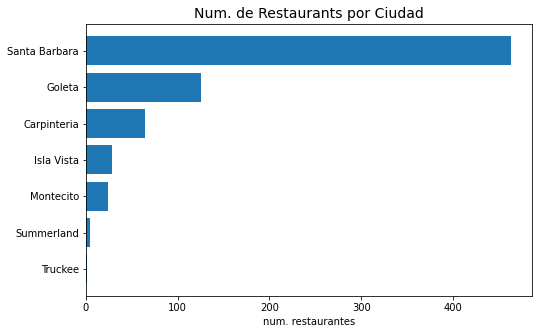

In [157]:
# sort the dictionary by its values in ascending order
sorted_data = dict(sorted(unique_counts.items(), key=lambda item: item[1]))

plt.figure(figsize=(8,5))

plt.barh(range(len(sorted_data)), list(sorted_data.values()), align='center')
plt.yticks(range(len(sorted_data)), list(sorted_data.keys()))

plt.title('Num. de Restaurants por Ciudad', size=14)
plt.xlabel('num. restaurantes')
plt.show()

In [76]:
# Extract the year from the timestamp
years = df_clean['date'].str[:4]

print('Las calificaciones de los usuarios son de los años:')
pd.DataFrame(years.sort_values().unique()).T

Las calificaciones de los usuarios son de los años:


,0,1,2,3
0,2019,2020,2021,2022


In [121]:
# Most reviewed restaurants

# get a sorted list of the unique restaurants in the column
most_reviews = sorted(df_clean['name'].unique())

# count the number of unique review_id occurrences for each restaurant
r_counts = df_clean.groupby('name')['review_id'].nunique().sort_index()

# create a dictionary of unique restaurants and their review counts
rev_counts = {}
for value in most_reviews:
    count = r_counts.get(value, 0)
    rev_counts[value] = count

sorted_revs = dict(sorted(rev_counts.items(), key=lambda item: item[1], reverse=True))  

df_revs = pd.DataFrame({'name':sorted_revs.keys(),
                        'n_reviews':sorted_revs.values()
                       }) 

In [122]:
print('Top 20 Restaurantes con mas reseñas:')
df_revs.head(20)

Top 20 Restaurantes con mas reseñas:


,name,n_reviews
0,Los Agaves,775
1,Boathouse at Hendry's Beach,692
2,Pickles & Swiss,626
3,Santa Barbara Shellfish Company,533
4,Finney's Crafthouse,459
5,Flor De Maiz,440
6,Santo Mezcal,413
7,Chad's,382
8,Oku,377
9,Lure Fish House,372


In [151]:
# Most popular restaurants with avg. rating and categories

df_avgcat = df_clean[['name','avg_rating', 'categories']]
df_pop = df_revs.merge(df_avgcat, how='inner', on = 'name')

popular = df_pop.drop_duplicates(subset='name', ignore_index=True)
popular.head()

,name,n_reviews,avg_rating_x,avg_rating_y,categories
0,Los Agaves,775,NaN,4.0,"Bars, Mexican, Nightlife, Restaurants"
1,Boathouse at Hendry's Beach,692,NaN,4.0,"Seafood, Restaurants, Hawaiian, American (New)..."
2,Pickles & Swiss,626,NaN,4.5,"Delis, Sandwiches, American (New), Restaurants"
3,Santa Barbara Shellfish Company,533,NaN,4.0,"Live/Raw Food, Restaurants, Seafood, Beer Bar,..."
4,Finney's Crafthouse,459,NaN,4.5,"Bars, American (Traditional), Gastropubs, Nigh..."


In [153]:
popular.drop(['avg_rating_x'], axis=1, inplace=True)
popular.rename(columns={'avg_rating_y':'avg_rating'}, inplace=True) 

/var/folders/kx/y44q1zf12s573t4djdfy9_n00000gn/T/ipykernel_74846/2913423546.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular.drop(['avg_rating_x'], axis=1, inplace=True)
/var/folders/kx/y44q1zf12s573t4djdfy9_n00000gn/T/ipykernel_74846/2913423546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popular.rename(columns={'avg_rating_y':'avg_rating'}, inplace=True)


In [154]:
# Table with the top 20 restaurants
top_20 = popular.head(20)
top_20

,name,n_reviews,avg_rating,categories
0,Los Agaves,775,4.0,"Bars, Mexican, Nightlife, Restaurants"
1,Boathouse at Hendry's Beach,692,4.0,"Seafood, Restaurants, Hawaiian, American (New)..."
2,Pickles & Swiss,626,4.5,"Delis, Sandwiches, American (New), Restaurants"
3,Santa Barbara Shellfish Company,533,4.0,"Live/Raw Food, Restaurants, Seafood, Beer Bar,..."
4,Finney's Crafthouse,459,4.5,"Bars, American (Traditional), Gastropubs, Nigh..."
5,Flor De Maiz,440,4.0,"Restaurants, Nightlife, Mexican, Bars, Cocktai..."
6,Santo Mezcal,413,4.5,"Latin American, Restaurants, Mexican, New Mexi..."
7,Chad's,382,4.0,"Diners, Salad, American (Traditional), Breakfa..."
8,Oku,377,4.0,"Bars, Tapas/Small Plates, Japanese, Nightlife,..."
9,Lure Fish House,372,4.5,"Breakfast & Brunch, Food, Beer, Wine & Spirits..."
